# Perfect all Factorio sciences grid

The goal of this notebook is to find the simplest grid that produces 1 unit/second of each of the Nauvis science packs, minimizing bot travel distance. Then, it generates a blueprint string to paste it into Factorio.

In [148]:
from base64 import b64encode
from collections import defaultdict
from json import dumps
from math import ceil
from matplotlib import pyplot as plt
from random import randint, random, shuffle
from zlib import compress

Now, let's define all recipes involved. I'm not using the actual game ids (i.e. automation-science-pack) because they are much longer than my invented names (i.e. red_science).

In [141]:
RECIPES = {
	'red_science': {'amount': 1, 'seconds': 5, 'ingredients': {'copper_plate': 1, 'gear': 1}},
	'gear': {'amount': 1, 'seconds': .5, 'ingredients': {'iron_plate': 2}},
	'green_science': {'amount': 1, 'seconds': 6, 'ingredients': {'transport_belt': 1, 'inserter': 1}},
	'transport_belt': {'amount': 2, 'seconds': .5, 'ingredients': {'iron_plate': 1, 'gear': 1}},
	'inserter': {'amount': 1, 'seconds': .5, 'ingredients': {'iron_plate': 1, 'gear': 1, 'green_circuit': 1}},
	'green_circuit': {'amount': 1, 'seconds': .5, 'ingredients': {'iron_plate': 1, 'copper_cable': 3}},
	'copper_cable': {'amount': 2, 'seconds': .5, 'ingredients': {'copper_plate': 1}},
	'black_science': {'amount': 2, 'seconds': 10, 'ingredients': {'piercing_red': 1, 'grenade': 1, 'wall': 2}},
	'piercing_red': {'amount': 1, 'seconds': 3, 'ingredients': {'copper_cable': 5, 'steel_plate': 1, 'piercing_yellow': 1}},
	'piercing_yellow': {'amount': 1, 'seconds': 1, 'ingredients': {'iron_plate': 4}},
	'grenade': {'amount': 1, 'seconds': 8, 'ingredients': {'coal': 10, 'iron_plate': 5}},
	'wall': {'amount': 1, 'seconds': .5, 'ingredients': {'stone_brick': 5}},
	'blue_science': {'amount': 2, 'seconds': 24, 'ingredients': {'sulfur': 1, 'red_circuit': 3, 'engine': 2}},
	'red_circuit': {'amount': 1, 'seconds': 6, 'ingredients': {'plastic': 2, 'copper_cable': 4, 'green_circuit': 2}},
	'engine': {'amount': 1, 'seconds': 10, 'ingredients': {'steel_plate': 1, 'gear': 1, 'pipe': 2}},
	'pipe': {'amount': 1, 'seconds': .5, 'ingredients': {'steel_plate': 1}},
	'pink_science': {'amount': 3, 'seconds': 21, 'ingredients': {'rail': 30, 'electric_furnace': 1, 'red_module': 1}},
	'rail': {'amount': 2, 'seconds': .5, 'ingredients': {'stone': 1, 'steel_plate': 1, 'iron_stick': 1}},
	'iron_stick': {'amount': 2, 'seconds': .5, 'ingredients': {'iron_plate': 1}},
	'electric_furnace': {'amount': 1, 'seconds': 5, 'ingredients': {'steel_plate': 10, 'red_circuit': 5, 'stone_brick': 10}},
	'red_module': {'amount': 1, 'seconds': 15, 'ingredients': {'green_circuit': 5, 'red_circuit': 5}},
	'yellow_science': {'amount': 3, 'seconds': 21, 'ingredients': {'blue_circuit': 2, 'robot_frame': 1, 'ld_structure': 3}},
	'blue_circuit': {'amount': 1, 'seconds': 10, 'ingredients': {'green_circuit': 20, 'red_circuit': 2, 'sulfuric_acid': 5}},
	'robot_frame': {'amount': 1, 'seconds': 20, 'ingredients': {'steel_plate': 1, 'battery': 2, 'green_circuit': 3, 'electric_engine': 1}},
	'electric_engine': {'amount': 1, 'seconds': 10, 'ingredients': {'green_circuit': 2, 'engine': 1, 'lubricant': 15}},
	'ld_structure': {'amount': 1, 'seconds': 15, 'ingredients': {'copper_plate': 20, 'steel_plate': 2, 'plastic': 5}}
}

SOURCES = {
	'minining': ('coal', 'stone'),
	'furnace': ('iron_plate', 'copper_plate', 'steel_plate', 'stone_brick'),
	'liquid': ('sulfuric_acid', 'lubricant'),
	'refinery': ('sulfur', 'plastic', 'battery')
}

INGAME_IDS = {
	'red_science': 'automation-science-pack',
	'gear': 'iron-gear-wheel',
	'green_science': 'logistic-science-pack',
	'transport_belt': 'transport-belt',
	'inserter': 'inserter',
	'green_circuit': 'electronic-circuit',
	'copper_cable': 'copper-cable',
	'black_science': 'military-science-pack',
	'piercing_red': 'piercing-rounds-magazine',
	'piercing_yellow': 'firearm-magazine',
	'grenade': 'grenade',
	'wall': 'stone-wall',
	'blue_science': 'chemical-science-pack',
	'red_circuit': 'advanced-circuit',
	'engine': 'engine-unit',
	'pipe': 'pipe',
	'pink_science': 'production-science-pack',
	'rail': 'rail',
	'iron_stick': 'iron-stick',
	'electric_furnace': 'electric-furnace',
	'red_module': 'productivity-module',
	'yellow_science': 'utility-science-pack',
	'blue_circuit': 'processing-unit',
	'robot_frame': 'flying-robot-frame',
	'electric_engine': 'electric-engine-unit',
	'ld_structure': 'low-density-structure'
}

Let's add an extra recipe that requires 1 unit per second of each science since that's what we want to build.

In [3]:
RECIPES['all_nauvis_science'] = {'amount': 1, 'seconds': 1, 'ingredients': {
	('%s_science' % color): 1
	for color in ('red', 'green', 'black', 'blue', 'pink', 'yellow')
}}
RECIPES['all_nauvis_science']

{'amount': 1,
 'seconds': 1,
 'ingredients': {'red_science': 1,
  'green_science': 1,
  'black_science': 1,
  'blue_science': 1,
  'pink_science': 1,
  'yellow_science': 1}}

We'll need a way to combine two lists of ingredients adding their amounts to a total.

In [4]:
def merge_lists(list1, list2):  # merge {<str>: <float|int>} dict keys adding the values and preserving the order
	res = list1.copy()
	for k, v in list2.items():
		res[k] = res.get(k, 0) + v
	return res

merge_lists({'a': 1, 'b': 2}, {'b': 3, 'c': 4})

{'a': 1, 'b': 5, 'c': 4}

Now, let's make a method that given an `item`, returns the assemblers and raw material throughputs required to sustain a certain production `rate`.

In [5]:
def full_recipe(item, rate=1):  # rate is the desired units per second of item
	recipe = RECIPES[item]
	total_assemblers = defaultdict(int, {item: rate * recipe['seconds'] / recipe['amount']})
	total_raw = defaultdict(int, {})
	for ingredient, amount in recipe['ingredients'].items():
		if ingredient in RECIPES:
			assemblers, raw = full_recipe(ingredient, amount * rate / recipe['amount'])
			total_assemblers = merge_lists(total_assemblers, assemblers)
			total_raw = merge_lists(total_raw, raw)
		else:
			total_raw[ingredient] += amount * rate / recipe['amount']
	return total_assemblers, total_raw

full_recipe('green_science', 1)

(defaultdict(int,
             {'green_science': 6.0,
              'transport_belt': 0.25,
              'gear': 0.75,
              'inserter': 0.5,
              'green_circuit': 0.5,
              'copper_cable': 0.75}),
 defaultdict(int, {'iron_plate': 5.5, 'copper_plate': 1.5}))

So let's run it and visualize what are the required assemblers and raw materials:

In [6]:
ROWS, COLS = 11, 18
SIZE = ROWS * COLS
assemblers, raw = full_recipe('all_nauvis_science', 1)
del assemblers['all_nauvis_science']
total_assemblers = sum(ceil(amount) for amount in assemblers.values())
grid_blocks = ceil(total_assemblers / SIZE)
print(f'Total assemblers: {total_assemblers} ({grid_blocks=}, empty_blocks={grid_blocks * SIZE - total_assemblers})')
for item, amount in assemblers.items():
	print(f'    {item.ljust(20)}{ceil(amount)} ({amount:.4f})')
print('Raw materials:')
for item, amount in raw.items():
	print(f'    {item.ljust(20)}{ceil(amount)} ({amount:.4f})')

Total assemblers: 197 (grid_blocks=1, empty_blocks=1)
    red_science         5 (5.0000)
    gear                2 (1.9167)
    green_science       6 (6.0000)
    transport_belt      1 (0.2500)
    inserter            1 (0.5000)
    green_circuit       15 (15.0000)
    copper_cable        30 (29.2917)
    black_science       5 (5.0000)
    piercing_red        2 (1.5000)
    piercing_yellow     1 (0.5000)
    grenade             4 (4.0000)
    wall                1 (0.5000)
    blue_science        12 (12.0000)
    red_circuit         37 (37.0000)
    engine              14 (13.3333)
    pipe                2 (1.3333)
    pink_science        7 (7.0000)
    rail                3 (2.5000)
    iron_stick          2 (1.2500)
    electric_furnace    2 (1.6667)
    red_module          5 (5.0000)
    yellow_science      7 (7.0000)
    blue_circuit        7 (6.6667)
    robot_frame         7 (6.6667)
    electric_engine     4 (3.3333)
    ld_structure        15 (15.0000)
Raw materials:
    coppe

Now let's make it into a grid of 18 x 11 assemblers, ensuring that the ones that process liquids are at the bottom.

In [7]:
grid = []
for item, amount in assemblers.items():
	for _ in range(ceil(amount)):
		grid.append(item)

liquid_assemblers = [item for item in grid if any(ingredient in SOURCES['liquid'] for ingredient in RECIPES[item]['ingredients'])]
dry_assemblers = [item for item in grid if item not in liquid_assemblers]
print(f'Liquid assemblers:')
for item in set(liquid_assemblers):
	print(f'    {item}: {liquid_assemblers.count(item)}')
shuffle(dry_assemblers)
grid = dry_assemblers + [None] * (SIZE - len(grid)) + liquid_assemblers

Liquid assemblers:
    blue_circuit: 7
    electric_engine: 4


The current distribution, after shuffling all non-liquid assemblers is as follows:

In [145]:
def print_grid(grid):
	print('row \\ col'.center(10) + ' '.join(str(i).center(10) for i in range(COLS)))
	for row in range(ROWS):
		print(str(row).center(10) + ' '.join((grid[row * COLS + col] or "-")[:10].center(10) for col in range(COLS)))

print_grid(grid)

row \ col     0          1          2          3          4          5          6          7          8          9          10         11         12         13         14         15         16         17    
    0         -      iron_stick pink_scien green_scie transport_ piercing_y green_scie copper_cab copper_cab red_circui electric_f electric_f blue_scien   engine   blue_scien   engine     engine      pipe   
    1     iron_stick pink_scien    rail    pink_scien green_scie piercing_r copper_cab copper_cab red_circui red_circui red_circui red_circui red_circui blue_scien blue_scien blue_scien   engine     engine  
    2     green_scie    rail       rail    pink_scien green_scie copper_cab red_circui copper_cab red_circui copper_cab copper_cab red_circui red_circui red_circui blue_scien blue_scien   engine     engine  
    3     green_scie pink_scien pink_scien pink_scien piercing_r copper_cab copper_cab red_circui copper_cab red_circui copper_cab copper_cab copper_cab red_circui blue

## Optimal placement

Now we want to find the best distribution that minimizes bot travel distance. For this, we will define a loss function that is represented by the distance from each assembler to all their required materials, weighted by how often this trip is done. For raw materials, we'll assume that they are all placed at the top center, and for research labs at the bottom center.

In [9]:
def loss(grid):
	return sum(penalty(grid, i) / RECIPES[item]['seconds'] for i in range(SIZE))

def penalty(grid, position):
	r, c = position // COLS, position % COLS
	if (item := grid[position]) is None: return 0
	res = 0
	for ingredient, amount in RECIPES[item]['ingredients'].items():
		if item in RECIPES:
			res += distance_to_all(grid, r, c, ingredient) * amount
		else:
			res += distance(r, c, -1, COLS // 2) * amount
	if '_science' == item[-8:]:
		res += distance(r, c, ROWS, COLS // 2) * RECIPES[item]['amount']
	return res


def distance_to_all(grid, r, c, item):
	res = 0
	for i, cell in enumerate(grid):
		if cell == item:
			res += distance(r, c, i // COLS, i % COLS)
	return res

def distance(r1, c1, r2, c2):
	return ((r1 - r2)**2 + (c1 - c2)**2)**.5

loss(grid)

11796.037750327596

The loss on top is the initial one with this random distribution. Now we need a function that swaps two assemblers (only the non-liquid) and recomputes the loss. We will define the temperature, which is the chance of applying that change even if it results in a worse overall distribution.

In [10]:
def mutate(grid, temperature=1):
	p1 = randint(0, SIZE - 1 -len(liquid_assemblers))
	while True:
		p2 = randint(0, SIZE - 1 -len(liquid_assemblers))
		if p1 != p2: break
	base = loss(grid)
	grid_swapped = grid.copy()
	grid_swapped[p1], grid_swapped[p2] = grid_swapped[p2], grid_swapped[p1]
	new = loss(grid_swapped)
	if new < base or random() < temperature:
		return grid_swapped, new
	return grid, base

grid, new_loss = mutate(grid, 0)
new_loss

11796.037750327596

Now, we can iteratively search for an optimal distribution by running the previous method while slowly decreasing the temperature. We will use an exponential decay rate.

In [11]:
losses = []
temperatures = []

def train(grid, iterations, decay_rate=.001):
	for it in range(iterations):
		t = decay_rate**(it / iterations) / (1 - decay_rate) - decay_rate
		grid, grid_loss = mutate(grid, t)
		temperatures.append(t)
		losses.append(grid_loss)
	return grid, grid_loss

grid, grid_loss = train(grid, 10**6)
grid_loss

6991.268982905046

Once a good state is found, we'll run a few cycles of mutations with temperature 0 (only accepting better states) to improve a bit on the result.

In [135]:
for _ in range(10000):
	grid, new_loss = mutate(grid, 0)
new_loss

6980.368529644536

Let's see how the loss decreased over time.

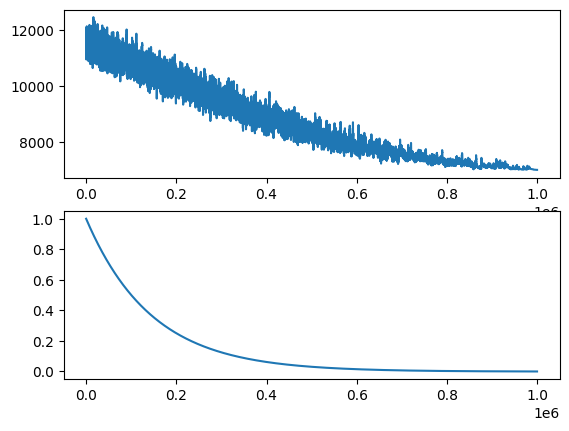

In [12]:
plt.subplot(2, 1, 1)
plt.plot(losses)
plt.subplot(2, 1, 2)
plt.plot(temperatures);

And let's visualize the resulting distribution.

In [146]:
print_grid(grid)

row \ col     0          1          2          3          4          5          6          7          8          9          10         11         12         13         14         15         16         17    
    0         -      iron_stick pink_scien green_scie transport_ piercing_y green_scie copper_cab copper_cab red_circui electric_f electric_f blue_scien   engine   blue_scien   engine     engine      pipe   
    1     iron_stick pink_scien    rail    pink_scien green_scie piercing_r copper_cab copper_cab red_circui red_circui red_circui red_circui red_circui blue_scien blue_scien blue_scien   engine     engine  
    2     green_scie    rail       rail    pink_scien green_scie copper_cab red_circui copper_cab red_circui copper_cab copper_cab red_circui red_circui red_circui blue_scien blue_scien   engine     engine  
    3     green_scie pink_scien pink_scien pink_scien piercing_r copper_cab copper_cab red_circui copper_cab red_circui copper_cab copper_cab copper_cab red_circui blue

I don't want to place that grid in game manually, so let's create a blueprint. Factorio blueprints are just a JSON file, compressed and encoded in base64.

In [151]:
def make_blueprint(grid):
	entities = []
	for i, item in enumerate(grid):
		entity = {
			'entity_number': i + 1,
			'name': 'assembling-machine-2',
			'position': {'x': (i % COLS) * 3 + 1.5, 'y': (i // COLS) * 3 + 1.5}
		}
		if item is not None:
			entity['recipe'] = INGAME_IDS[item]
			entity['recipe_quality'] = 'normal'
		entities.append(entity)
	res = {
		'blueprint': {
			'item': 'blueprint',
			'entities': entities,
			'icons': [{'signal': {'name': 'assembling-machine-2'}, 'index': 1}],
			'version': 562949954142211
		}
	}
	res = compress(dumps(res, separators=(',', ':')).encode('utf-8'))
	return '0' + b64encode(res).decode('utf-8')

make_blueprint(grid)

'0eJy1neFuo0YUhd+F36YyzAAmr7KqVgRPnFExuAMkTaO8eyGpYUu4lc6dO792Nxs8n8b2xwHfk7xHj81obs62Q/TwHtnBXKOHX752iEw72MGaPnr48f71j7ef7Xh9NC56SA5RW13NdETV9+b62Nj2El+r+tm2Jk6ng29dPx3ctfNj/zV9/2/ZIXr7/PPj4/Dt4VLw4fQvD3eInKntbT7Yuq6N+8HWf0T3r/78c6yaaanpf9vOXasm2llegcsX+8vfXHce6/n74r62pq1NfKtQFo3u7HEfpukudt4KD5QMRVH7KIOr2v7WuSF+NM2AMeQoQ77P8GSdqdx1OvRS/T0di1EUKEUZ7Ek5gShpuo9Sd7ebcXFdPTbgZpQoQSZNkBxRhNM+QnV+qaan4RzX1tWjBV+bCWpBlexjmMbUg5teFk+ja6sa3Q3UnorQpycGalFFaLR+NldbV43HmyRBLaoJi5r2Mh8xtvBrA5WnJuQpsRuoRDUhUf5uoALVhED5BKg3M8Kbt/kPbGlUmHdLaJl0k6K21Pvri8SbFHVmsQ/jKtuAK6OaXJJVkH1AbbmEKy0eKVI4c+bEzljj6vlY143tuWeGrRTOneU+Dj9gpKgxl5Qlh4Aqc4lZWjLjpHDePAXBQB2qCIn6YShUpYpwqScGHDwJi3piwJfthFEFMo5CfaoJn0qwwOmT8KkEC5xDCZmyk5dCXZoRLuUTwJfv/wIU4qdahepU76Pg8UehBi2kVtaoNJfgVQQIXhq+damCvRo0HEnzfRZ+zNBwDi33EfxOJRpV5hK45HYCNeUSuGR3Ao6eJ/GdQH2pCGF6IKCeVIQoPZ8MOHYS1vTDyOAreMKgnhioOjWhToFck8HZk1KnAAucPQmHshNOhuozI/TJJ4Av2u+3147yn1vB9zsJFpHAkaE2LYLSoGJdP18MggPfG1UUjsi9pxzOqjnBwz/35XBCLeUZUL2uHzMeJU85OarW9cNGub2As+kpzF6gil

Great! Now we can paste the previous string in the game and have a nice grid distribution. If you've read until here, feel free to add new recipes and change the ROWS and COLS to create your own grids for other purposes. Aside from this research block, I'm also using a utility block, a block of items that should be carried to new mines, a block of items to take to space...